In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from midiutil import MIDIFile

import random

In [ ]:
## Constraints
# 1. # of pianists, 2 hands, 5 fingers
# 2. time apart
# 3. spatial apart (in each hand cannot exceed one octave)
# 4. within one octave > same intensity > notes start at the same time > last for same period > not adjacent

In [2]:
## Parameters
GroupNum = 21 * 2 #21 pianists, 2 hands each
max_note_per_group = 5 #5 fingers

#min_pitch_gap = not set
win_length = 50e-3
max_time_gap = 0.3
max_frame_gap = int(round(max_time_gap / win_length))

In [3]:
key_time = 50e-3*0.5
Fs = 48000

#keys = scipy.io.loadmat('MATLAB_data/31Jan_jc.mat')['key']
keys = scipy.io.loadmat('MATLAB_data/doing_tdy_88.mat')['key']
notes_list = scipy.io.loadmat('notes_88.mat')['notes']
freq_list = scipy.io.loadmat('freq_480.mat')['f_cropped']
#freq_list = scipy.io.loadmat('freq_441.mat')['f_cropped']
notes_list = notes_list.reshape(np.size(notes_list))
freq_list = freq_list.reshape(np.size(freq_list))

def get_intensity(cur_key,cur_freq,wave_freq):
    if cur_key == 1:
        sigma = notes_list[1]-notes_list[0]
    else:
        sigma = notes_list[cur_key-1]-notes_list[cur_key-2]
    sigma = sigma/2
    intensity = np.exp(-0.5 *((cur_freq-wave_freq)/sigma)**2)
    #print('cur', cur_freq,'wave',wave_freq)
    return intensity

def picknotes(cur_key,cur_freq):
    j = 0
    while j < len(cur_key):
        if cur_key[j] != 0:
            
            d = {}
            d['note'] = cur_key[j]
            d['start'] = j
            while cur_key[j] != 0 and j < len(cur_key)-1:
                j += 1
            d['end'] = j - 1
            intensity = get_intensity(cur_key[j-1],cur_freq,notes_list[cur_key[j-1]-1])
            d['intensity'] = intensity
            notes.append(d)
        j += 1

notes = []
for i in range(np.shape(keys)[0]):
    cur_key = keys[i]
    cur_freq = freq_list[i]
    picknotes(cur_key,cur_freq)

notes = sorted(notes, key = lambda notes: notes["start"])

def remove_repetitive(notes):
    note_set = [0]*88
    i = 0
    while i < len(notes):
        note = notes[i]
        if note_set[note['note']-1] == 0:
            note_set[note['note']-1] = [(note['start'],note['end'])]
        else:
            if (note['start'],note['end']) in note_set[note['note']-1]:
                del notes[i]
                i -= 1
            else:
                note_set[note['note']-1].append((note['start'],note['end']))
        i += 1
    return notes

new_notes = remove_repetitive(notes)

In [ ]:
#Separate notes into C major and Gb major
def separate_majors(notes):
    C_major = [1,3,4,6,8,9,11]
    Gb_major = [0,2,3,5,7,9,10]

    C_notes = []
    Gb_notes = []

    for i,note in enumerate(notes):
        seq = note['note'] % 12
        if (seq in C_major) and (seq not in Gb_major):
            C_notes.append(notes.pop(i))
        elif (seq in Gb_major) and (seq not in C_major):
            Gb_notes.append(notes.pop(i))

    for i,note in enumerate(notes):
        if i % 2 == 0:
            C_notes.append(notes.pop(i))
        else:
            Gb_notes.append(notes.pop(i))
    return [C_notes, Gb_notes]

In [ ]:
def group_notes(notes_list):
    ### change [{'note':pitch_num, 'start':start_time,'end':end_time}] to 
    return

In [4]:
word_gap = 15
def separate_word(notes):
    word_list = []
    ptr = 0
    for i in range(len(notes)-1):
        if notes[i+1]['start'] - notes[i]['end'] >= word_gap:
            word_list.append(notes[ptr:i+1])
            ptr = i + 1
        if i == len(notes) - 2:
            word_list.append(notes[ptr:])
    return word_list
    

In [5]:
separate = False



In [6]:
def print_list(l):
    for i in l:
        print(i)

In [7]:
def add_note(pitch_group,note,current_group,notes_group):
    pitch_group.append(note['note'])
    current_group.append(note)
    notes_group.remove(note)
    return pitch_group,current_group,notes_group

In [19]:
def allocation(notes_group):
    allocated_notes=[]
    group = 1
    overlapped = False #true if last group was left hand, current group is right hand, they should not overlap
    while notes_group != [] and group <= GroupNum:
        current_group = []
        if not overlapped:
            pitch_group = [notes_group[0]['note']]
            current_group.append(notes_group.pop(0))
        else:
            for i in range(len(notes_group)):
                if notes_group[i]['note'] > (high + 1):
                    pitch_group = [notes_group[i]['note']]
                    current_group.append(notes_group.pop(i))
                    break
        for current_allocated_note in current_group:
            #print('current_group',current_group)
            #print(pitch_group)
            candidate = []
            # counter = 0
            for note in notes_group:
                if (note['note'] not in pitch_group) and (note['note']-min(pitch_group) <= 12):
                    #print(note['note'])
                    if overlapped and note['note'] < (high + 1):
                        break
                    #print('in')
                    if note['start'] == current_allocated_note['start']:
                        if note['end'] == current_allocated_note['end']:
                            candidate.append([1,note])
                            # counter += 1
                        else:
                            candidate.append([2,note])
                            # counter += 1
                    elif note['end'] == current_allocated_note['end']:
                        candidate.append([3,note])
                    #     counter += 1
                    # elif counter == 4:
                    #     continue
                    else:    
                        candidate.append([4,note])
            #print_list(candidate)
        candidate.sort(key = lambda x: x[0])
        #print('candidate')
        #print_list(candidate)
        counter = 0
        while len(current_group) < 5 and counter < len(candidate):
            if candidate[counter][1]['note'] not in pitch_group:
                pitch_group,current_group,notes_group = add_note(pitch_group,candidate[counter][1],current_group,notes_group)
            counter += 1
                                
        #print(current_group)

        if not overlapped:
            high = 0
            for note in current_group:
                high = max(high,note['note'])

        allocated_notes.append(current_group)

        overlapped = not overlapped
        group += 1 #finish allocate notes to one group, update
    
    if notes_group != []:
        print('Failed to allocate :(')
        print(len(notes_group))
        return False
    else:
        return allocated_notes

In [ ]:
if separate:
    ### TOBE FINISHED
    notes_groups = separate_majors(notes)
    result = []
    # for group in notes_groups:
    #     word_groups = separate_word(group)
    #     r = allocation(group)
    #     if not r:
    #         result.append(r)
    #     else:
    #         break
else:
    new_notes = sorted(new_notes, key = lambda notes: notes["start"])
    word_groups = separate_word(new_notes)
    #result = allocation(notes)

In [ ]:
adjacent_note_gap = 0

In [9]:
## visualization tool
def plot_notes(note_list):
    time =[]
    pitch = []
    for note in note_list:
        time.append(note['start'])
        pitch.append(note['note'])
    plt.scatter(time,pitch,s=1)

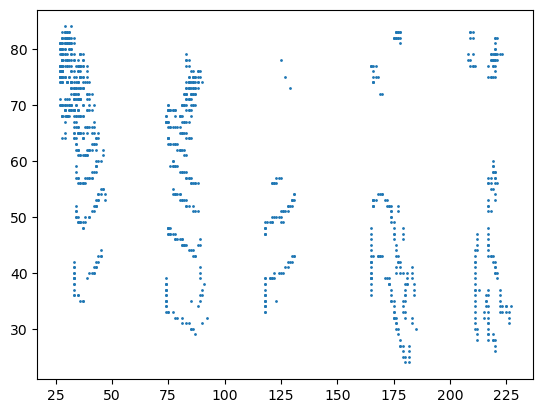

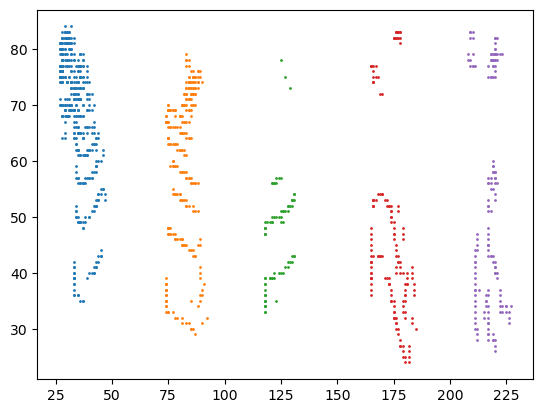

In [10]:
plot_notes(new_notes)
plt.show()
word_groups = separate_word(new_notes)
for g in word_groups:
    plot_notes(g)
plt.show()

In [11]:
for item in word_groups:
    print(len(item))

449
260
78
158
154


In [ ]:
for node in word_groups[0]:
    print(node)
print(len(word_groups[0]))

In [23]:
word_groups = separate_word(new_notes)
test_group = word_groups[2].copy()
result = False
while not result:
    result = allocation(test_group)
    test_group = word_groups[2].copy()
    random.shuffle(test_group)

C:\Users\96326\AppData\Local\Temp\ipykernel_21768\3771347501.py:22: RuntimeWarning: overflow encountered in ubyte_scalars
  if (note['note'] not in pitch_group) and (note['note']-min(pitch_group) <= 12):


In [50]:
word_groups = separate_word(new_notes)
final_allocation = [[],[]]
for i in range(2,5):
    print(i)
    current_allocate_group = word_groups[i].copy()
    result = False
    while not result:
        result = allocation(current_allocate_group)
        current_allocate_group = word_groups[i].copy()
        random.shuffle(current_allocate_group)
    
    final_allocation[0].extend(result[0])
    final_allocation[1].extend(result[1])
    print(final_allocation)
    print('success')

    

2
[[{'note': 33, 'start': 118, 'end': 118, 'intensity': 0.9337658603499376}, {'note': 39, 'start': 118, 'end': 118, 'intensity': 0.8067382219820456}, {'note': 34, 'start': 118, 'end': 119, 'intensity': 0.6292243666288175}, {'note': 35, 'start': 118, 'end': 121, 'intensity': 0.7678684795583712}, {'note': 36, 'start': 118, 'end': 126, 'intensity': 0.82167013228532}], [{'note': 47, 'start': 118, 'end': 118, 'intensity': 0.9973891162765615}, {'note': 48, 'start': 118, 'end': 120, 'intensity': 0.7070269205403353}, {'note': 49, 'start': 118, 'end': 123, 'intensity': 0.7013799383805369}, {'note': 50, 'start': 121, 'end': 126, 'intensity': 0.6305401509327592}, {'note': 56, 'start': 121, 'end': 121, 'intensity': 0.8310590717712135}]]
success
3
Failed to allocate :(
39
Failed to allocate :(
1
Failed to allocate :(
9
Failed to allocate :(
10
Failed to allocate :(
7
Failed to allocate :(
6
[[{'note': 33, 'start': 118, 'end': 118, 'intensity': 0.9337658603499376}, {'note': 39, 'start': 118, 'end': 

C:\Users\96326\AppData\Local\Temp\ipykernel_21768\3771347501.py:22: RuntimeWarning: overflow encountered in ubyte_scalars
  if (note['note'] not in pitch_group) and (note['note']-min(pitch_group) <= 12):


In [34]:
print(final_allocation)

[[{'note': 33, 'start': 118, 'end': 118, 'intensity': 0.9337658603499376}, {'note': 39, 'start': 118, 'end': 118, 'intensity': 0.8067382219820456}, {'note': 34, 'start': 118, 'end': 119, 'intensity': 0.6292243666288175}, {'note': 35, 'start': 118, 'end': 121, 'intensity': 0.7678684795583712}, {'note': 36, 'start': 118, 'end': 126, 'intensity': 0.82167013228532}, {'note': 44, 'start': 176, 'end': 178, 'intensity': 0.6862225671838764}, {'note': 45, 'start': 176, 'end': 178, 'intensity': 0.6908760446160362}, {'note': 52, 'start': 173, 'end': 173, 'intensity': 0.8094166400593618}, {'note': 46, 'start': 165, 'end': 165, 'intensity': 0.6292243666288175}, {'note': 53, 'start': 166, 'end': 173, 'intensity': 0.827769730861526}, {'note': 34, 'start': 222, 'end': 223, 'intensity': 0.9139161392383283}, {'note': 37, 'start': 222, 'end': 223, 'intensity': 0.8106775193961244}, {'note': 36, 'start': 222, 'end': 223, 'intensity': 0.82167013228532}, {'note': 35, 'start': 222, 'end': 223, 'intensity': 0.

In [45]:
mf = MIDIFile(2)     # only 1 track
#track = 0   # the only track
time = 0    # start at the beginning
mf.addTrackName(0, time, "Right")
mf.addTrackName(1, time, "Left")
mf.addTempo(0, time, 1200)
mf.addTempo(1, time, 1200)

In [46]:
for i in range(2):    
    for note in final_allocation[1-i]:
        mf.addNote(i,i,note['note']+20, note['start'], note['end']-note['start']+1,100)

In [47]:
with open("midifile/allocation_test_2.mid", 'wb') as outf:
   mf.writeFile(outf)

In [49]:
l = 0
for i in result:
    l += len(i)
    print(i)
print(l == len(word_groups[4]))

[{'note': 40, 'start': 211, 'end': 211, 'intensity': 0.6161451804438065}, {'note': 41, 'start': 211, 'end': 211, 'intensity': 0.7439560185650197}, {'note': 42, 'start': 211, 'end': 211, 'intensity': 0.619504134234769}, {'note': 43, 'start': 211, 'end': 212, 'intensity': 0.6068171573270504}, {'note': 44, 'start': 211, 'end': 212, 'intensity': 0.6862225671838764}]
[{'note': 78, 'start': 218, 'end': 222, 'intensity': 0.9773322307453254}, {'note': 79, 'start': 218, 'end': 222, 'intensity': 0.6068171573270524}, {'note': 83, 'start': 209, 'end': 210, 'intensity': 0.89059644161312}, {'note': 82, 'start': 210, 'end': 210, 'intensity': 0.8123317807840695}, {'note': 80, 'start': 220, 'end': 220, 'intensity': 0.7244317229962931}]
[{'note': 45, 'start': 212, 'end': 212, 'intensity': 0.6908760446160362}, {'note': 47, 'start': 212, 'end': 212, 'intensity': 0.6398581138821163}, {'note': 46, 'start': 212, 'end': 212, 'intensity': 0.6292243666288175}, {'note': 57, 'start': 218, 'end': 218, 'intensity':

In [ ]:
        # candidate = []
        # for i,note in enumerate(notes_group):
        #     if (note['note'] not in pitch_group) and (note['note']-pitch_group[0] <= 12):
        #         if overlapped and note['note'] > (high + 1):
        #             candidate.append(note)
        #         elif not overlapped:
        #             candidate.append(note)
        # for c in candidate:
        #     print(c)
        # for j,note in enumerate(candidate):
        #     if len(current_group) == 5:
        #         break
        #     for current_allocated_note in current_group:
        #         if note['start'] == current_allocated_note['start'] and note['end'] == current_allocated_note['end']:
        #             current_group.append(candidate.pop(j))
        #             notes_group.remove(note)
            
        # for j,note in enumerate(candidate):
        #     if len(current_group) == 5:
        #         break
        #     for current_allocated_note in current_group:
        #         if note['start'] == current_allocated_note['start']:
        #             current_group.append(candidate.pop(j))
        #             notes_group.remove(note)
            
        # for j,note in enumerate(candidate):
        #     if len(current_group) == 5:
        #         break
        #     for current_allocated_note in current_group:
        #         if note['end'] == current_allocated_note['end']:
        #             current_group.append(candidate.pop(j))
        #             notes_group.remove(note)

        # if len(current_group) != 5:
        #     for k in range(5-len(current_group)):
        #         current_group.append(candidate.pop(k))
        #         notes_group.remove(candidate[k])